In [1]:
import keras_tuner as kt

## Load data


In [2]:
# Import the dataset loading function from sklearn
from sklearn.datasets import load_digits

# Load the hand-written digits dataset
digits = load_digits()

# Get the images and corresponding labels
images, labels = digits.images, digits.target
images.shape, labels.shape


((1797, 8, 8), (1797,))

## Exploratory data analysis & Data preprocessing &  feature engineering


In [3]:
# reshape images to vectors
n_samples = len(images)
X = images.reshape((n_samples, -1))
X.shape


(1797, 64)

In [4]:
# Split data into train and test subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, shuffle=False
)

print("Shape of the training data: {}".format(X_train.shape))
print("Shape of the testing data: {}".format(X_test.shape))


Shape of the training data: (1437, 64)
Shape of the testing data: (360, 64)


In [5]:
X_train.shape, X_test.shape


((1437, 64), (360, 64))

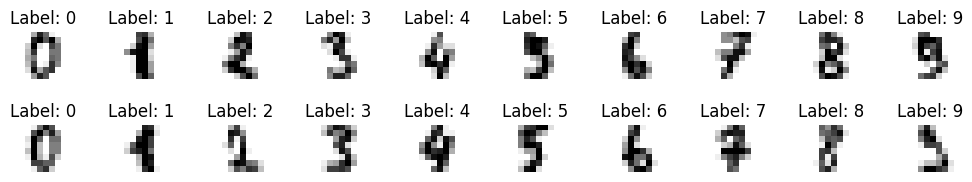

In [6]:
import matplotlib
import matplotlib.pyplot as plt

# plot first 20 images
n = 20
_, axes = plt.subplots(2, 10, figsize=(10, 2))
plt.tight_layout()
for i in range(n):
    row, col = i // 10, i % 10
    axes[row, col].set_axis_off()
    axes[row, col].imshow(
        images[
            i,
        ],
        cmap=plt.cm.gray_r,
        interpolation="nearest",
    )
    axes[row, col].set_title("Label: %i" % labels[i])


## KerasTuner tuning: joint hyperparameter tuning and model selection


In [7]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras_tuner.engine import hyperparameters as hp


def build_model(hp):
    model_type = hp.Choice("model_type", ["svm", "random_forest"])
    if model_type == "svm":
        with hp.conditional_scope("model_type", "svm"):
            model = SVC(
                C=hp.Float("C", 1e-3, 10, sampling="linear", default=1),
                kernel=hp.Choice("kernel_type", ["linear", "rbf"], default="linear"),
                random_state=42,
            )
    elif model_type == "random_forest":
        with hp.conditional_scope("model_type", "random_forest"):
            model = RandomForestClassifier(
                n_estimators=hp.Int("n_estimators", 10, 200, step=10),
                max_depth=hp.Int("max_depth", 3, 10),
            )
    else:
        raise ValueError("Unrecognized model_type")
    return model



### Random Search Algorithm


In [8]:
from sklearn.model_selection import KFold
import sklearn.pipeline

random_tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.RandomSearch(
        objective=kt.Objective("score", "max"), max_trials=30, seed=42
    ),
    hypermodel=build_model,
    cv=KFold(3, shuffle=True, random_state=42),
    overwrite=True,
    project_name="random_tuner",
)

random_tuner.search(X_train, y_train)


Trial 30 Complete [00h 00m 01s]
score: 0.9568545581071676

Best score So Far: 0.9937369519832986
Total elapsed time: 00h 00m 29s


In [9]:
random_tuner.search_space_summary()


Search space summary
Default search space size: 5
model_type (Choice)
{'default': 'svm', 'conditions': [], 'values': ['svm', 'random_forest'], 'ordered': False}
C (Float)
{'default': 1, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'min_value': 0.001, 'max_value': 10.0, 'step': None, 'sampling': 'linear'}
kernel_type (Choice)
{'default': 'linear', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'values': ['linear', 'rbf'], 'ordered': False}
n_estimators (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': 'linear'}
max_depth (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 3, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


In [10]:
random_tuner.results_summary(1)


Results summary
Results in ./random_tuner
Showing 1 best trials
Trial summary
Hyperparameters:
model_type: svm
C: 4.211025098252177
kernel_type: rbf
Score: 0.9937369519832986


In [11]:
# Evaluate the best discovered model
from sklearn.metrics import accuracy_score

best_model = random_tuner.get_best_models(1)[0]
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy on test set: {:.2f} %".format(test_acc * 100))


The prediction accuracy on test set: 95.83 %


## KerasTuner tuning: whole pipeline with shallow models


In [12]:
from keras_tuner.engine import hyperparameters as hp
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


def build_pipeline(hp):

    # select hyperparameters of PCA
    n_components = hp.Choice("n_components", [2, 5, 10], default=5)
    pca = PCA(n_components=n_components)

    # select model type
    model_type = hp.Choice("model_type", ["svm", "random_forest"])
    if model_type == "svm":
        with hp.conditional_scope("model_type", "svm"):
            model = SVC(
                C=hp.Float("C", 1e-3, 10, sampling="linear", default=1),
                kernel=hp.Choice("kernel_type", ["linear", "rbf"], default="linear"),
                random_state=42,
            )
    elif model_type == "random_forest":
        with hp.conditional_scope("model_type", "random_forest"):
            model = RandomForestClassifier(
                n_estimators=hp.Int("n_estimators", 10, 200, step=10),
                max_depth=hp.Int("max_depth", 3, 10),
            )
    else:
        raise ValueError("Unrecognized model_type")

    # create pipeline
    pipeline = Pipeline([("pca", pca), ("clf", model)])

    return pipeline


tuner = kt.tuners.Sklearn(
    oracle=kt.oracles.RandomSearch(
        objective=kt.Objective("score", "max"), max_trials=3
    ),
    hypermodel=build_pipeline,
    overwrite=True,
)
tuner.search(X_train, y_train)


Trial 3 Complete [00h 00m 01s]
score: 0.9352956833139761

Best score So Far: 0.9798151374370887
Total elapsed time: 00h 00m 02s


In [13]:
tuner.results_summary(1)


Results summary
Results in ./untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
n_components: 10
model_type: svm
C: 7.8893955430007985
kernel_type: rbf
Score: 0.9798151374370887


In [14]:
# Evaluate the best discovered model
from sklearn.metrics import accuracy_score

best_pipeline = tuner.get_best_models(1)[0]
best_pipeline.fit(X_train, y_train)
y_pred_test = best_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy on test set: {:.2f} %".format(test_acc * 100))


The prediction accuracy on test set: 94.44 %


In [15]:
bo_tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimization(
        objective=kt.Objective("score", "max"), max_trials=30, seed=42
    ),
    hypermodel=build_pipeline,
    cv=KFold(3, shuffle=True, random_state=42),
    overwrite=True,
    project_name="bo_tuner",
)

bo_tuner.search(X_train, y_train)


Trial 30 Complete [00h 00m 00s]
score: 0.9798190675017397

Best score So Far: 0.9819067501739736
Total elapsed time: 00h 00m 50s


In [16]:
bo_tuner.search_space_summary()


Search space summary
Default search space size: 6
n_components (Choice)
{'default': 5, 'conditions': [], 'values': [2, 5, 10], 'ordered': True}
model_type (Choice)
{'default': 'svm', 'conditions': [], 'values': ['svm', 'random_forest'], 'ordered': False}
C (Float)
{'default': 1, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'min_value': 0.001, 'max_value': 10.0, 'step': None, 'sampling': 'linear'}
kernel_type (Choice)
{'default': 'linear', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['svm']}}], 'values': ['linear', 'rbf'], 'ordered': False}
n_estimators (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': 'linear'}
max_depth (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'model_type', 'values': ['random_forest']}}], 'min_value': 3,

In [17]:
bo_tuner.results_summary(1)


Results summary
Results in ./bo_tuner
Showing 1 best trials
Trial summary
Hyperparameters:
n_components: 10
model_type: svm
C: 3.706195854321974
kernel_type: rbf
Score: 0.9819067501739736


In [18]:
# Evaluate the best discovered model
from sklearn.metrics import accuracy_score

best_model = bo_tuner.get_best_models(1)[0]
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print("The prediction accuracy on test set: {:.2f} %".format(test_acc * 100))


The prediction accuracy on test set: 94.44 %


# Automated Feature Engineering


In [19]:
import tensorflow as tf

TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)


13049/13049 [==============================] - 0s 0us/step


In [20]:
import pandas as pd

x_train = pd.read_csv(train_file_path)
y_train = x_train.pop("survived")
y_train = pd.DataFrame(y_train)

x_test = pd.read_csv(test_file_path)
y_test = x_test.pop("survived")

x_train.head()


,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [21]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numerical_columns = ["age", "fare"]
one_hot_columns = ["n_siblings_spouses", "class"]
int_columns = ["sex", "parch", "deck", "embark_town", "alone"]

numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("normalizer", StandardScaler()),
    ]
)

one_hot_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

int_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
        (
            "label_encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        ),
    ]
)


In [22]:
from sklearn.base import BaseEstimator, TransformerMixin


class CategoricalCombination(BaseEstimator, TransformerMixin):
    def __init__(self, name_a, name_b):
        self.name_a = name_a
        self.name_b = name_b
        self.encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1
        )

    def fit(self, x, y=None, **kwargs):
        temp_column = x[self.name_a].astype(str) + x[self.name_b].astype(str)
        self.encoder.fit(temp_column.to_frame())
        return self

    def transform(self, x, **kwargs):
        temp_column = x[self.name_a].astype(str) + x[self.name_b].astype(str)
        temp_column = self.encoder.transform(temp_column.to_frame())
        return temp_column



In [23]:
temp_data = pd.DataFrame({"1": ["A", "A", "A", "B", "B", "B"], "2": [1, 0, 1, 0, 1, 1]})
print(temp_data.head(6))


   1  2
0  A  1
1  A  0
2  A  1
3  B  0
4  B  1
5  B  1


In [24]:
transformer = CategoricalCombination("1", "2")
print(transformer.fit_transform(temp_data))


[[1.]
 [0.]
 [1.]
 [2.]
 [3.]
 [3.]]


In [25]:

class MeanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_name, numerical_name):
        self.categorical_name = categorical_name
        self.numerical_name = numerical_name
        self.means = None

    def fit(self, x, y=None, **kwargs):
        self.mean = x.groupby(self.categorical_name)[self.numerical_name].mean()
        return self

    def transform(self, x, **kwargs):
        return x[self.categorical_name].map(self.mean).to_frame()



In [26]:
temp_data = pd.DataFrame(
    {"a": ["A", "A", "B", "B", "C", "C"], "b": [1, 1, 1, 0, 1, -1]}
)
print(temp_data.head(6))
encoder = MeanEncoder("a", "b")
print(encoder.fit_transform(temp_data).head(6))


   a  b
0  A  1
1  A  1
2  B  1
3  B  0
4  C  1
5  C -1
     a
0  1.0
1  1.0
2  0.5
3  0.5
4  0.0
5  0.0


In [27]:
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numerical_columns),
        ("one_hot", one_hot_transformer, one_hot_columns),
        ("int", int_transformer, int_columns),
        (
            "categorical_combination",
            CategoricalCombination("sex", "class"),
            ["sex", "class"],
        ),
        ("mean", MeanEncoder("embark_town", "age"), ["embark_town", "age"]),
    ]
)


In [28]:
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

pipeline = Pipeline(
    steps=[
        ("preprocessing", column_transformer),
        ("feature_selection", SelectKBest(mutual_info_classif, k=8)),
        ("model", SVC()),
    ]
)
pipeline.fit(x_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('normalizer',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['n_sibl...
                                                  ['sex', 'parch', 'deck',
                                                   'embark_town', 'alone']),
                                                 ('categorical_combination',
                                                  CategoricalCombination(name_a='sex',
                                                                         name_b='class'),
                                                  ['sex', 'class']),
                                                 ('mean',
                                                  MeanEncoder(categorical_name='embark_town',
                                                              numerical_name='age'),
                                                  ['embark_town', 'age'])])),
                ('feature_selection',
                 SelectKBest(k=8,
                             score_func=<function mutual_info_classif at 0x7ca2b02644c0>)),
                ('model', SVC())])

In [29]:
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))


Accuracy:  0.7424242424242424


In [30]:
import numpy as np

mean_column_pairs = []
for int_col in int_columns:
    for num_col in numerical_columns:
        mean_column_pairs.append((int_col, num_col))

cat_column_pairs = []
for index1 in range(len(int_columns)):
    for index2 in range(index1 + 1, len(int_columns)):
        cat_column_pairs.append((int_columns[index1], int_columns[index2]))

mean_column_pairs = np.array(mean_column_pairs)
cat_column_pairs = np.array(cat_column_pairs)


In [31]:
transformers = []
for index, (col1, col2) in enumerate(cat_column_pairs):
    if not hp.Boolean("combine_{i}".format(i=index)):
        continue
    col1 = str(col1)
    col2 = str(col2)
    transformers.append((col1 + col2, CategoricalCombination(col1, col2), [col1, col2]))


In [32]:
import keras_tuner as kt


def build_model(hp):
    numerical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("normalizer", StandardScaler()),
        ]
    )

    one_hot_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
            ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    int_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
            (
                "label_encoder",
                OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            ),
        ]
    )

    transformers = [
        ("numerical", numerical_transformer, numerical_columns),
        ("one_hot", one_hot_transformer, one_hot_columns),
        ("int", int_transformer, int_columns),
    ]
    for index, (col1, col2) in enumerate(cat_column_pairs):
        if not hp.Boolean("combine_{i}".format(i=index)):
            continue
        col1 = str(col1)
        col2 = str(col2)
        transformers.append(
            (col1 + col2, CategoricalCombination(col1, col2), [col1, col2])
        )

    for index, (col1, col2) in enumerate(mean_column_pairs):
        if not hp.Boolean("mean_{i}".format(i=index)):
            continue
        col1 = str(col1)
        col2 = str(col2)
        transformers.append((col1 + col2, MeanEncoder(col1, col2), [col1, col2]))
    print(transformers)
    pipeline = Pipeline(
        steps=[
            ("preprocessing", ColumnTransformer(transformers=transformers)),
            ("impute", SimpleImputer(strategy="median")),
            (
                "model_selection",
                SelectKBest(
                    mutual_info_classif,
                    k=hp.Int("best_k", 5, 13 + len(transformers) - 3),
                ),
            ),
            ("model", SVC()),
        ]
    )

    return pipeline



In [33]:
build_model(kt.HyperParameters()).fit(x_train, y_train)


[('numerical', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('normalizer', StandardScaler())]), ['age', 'fare']), ('one_hot', Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='None', strategy='constant')),
                ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]), ['n_siblings_spouses', 'class']), ('int', Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='None', strategy='constant')),
                ('label_encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1))]), ['sex', 'parch', 'deck', 'embark_town', 'alone'])]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('normalizer',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['n_sibl...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('label_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['sex', 'parch', 'deck',
                                                   'embark_town', 'alone'])])),
                ('impute', SimpleImputer(strategy='median')),
                ('model_selection',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x7ca2b02644c0>)),
                ('model', SVC())])

In [34]:
from sklearn import metrics
import sklearn

tuner = kt.SklearnTuner(
    kt.oracles.RandomSearchOracle(
        objective=kt.Objective("score", "max"),
        max_trials=10,
    ),
    build_model,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    overwrite=True,
)
tuner.search(x_train, y_train)


Trial 10 Complete [00h 00m 01s]
score: 0.797384126984127

Best score So Far: 0.8053714285714285
Total elapsed time: 00h 00m 11s
